In [1]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

from statsmodels.formula.api import ols

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam, Adamax

from tensorflow.keras.layers import Dense, Concatenate, Activation
from tensorflow.keras.metrics import RootMeanSquaredError
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

In [2]:
#aa = "A01"
aa = "A02"
#aa = "A03"
#aa = "A04"
#aa = "A05"
#aa = "A06"
A0=pd.read_csv(aa+".csv",encoding="utf-8-sig")

In [3]:
A0["de_dt"] = pd.to_datetime(A0["de_dt"].astype(int).astype(str))
A0

,cust,ma_fem_dv,ages,zon_hlv_x,rct_no,chnl_dv,cop_c,pd_c,pd_nm,clac_hlv_nm,clac_mcls_nm,buy_am,buy_ct,de_dt,de_hr,br_c,zon_hlv_y,zon_mcls
0,M000419293,여성,40대,Z17,A02041463489,1.0,A02,PD0777,남성런닝/트레이닝화,스포츠패션,남성스포츠화,3000.0,3.0,2021-01-29,14.0,A020008,Z17,Z17011
1,M000419293,여성,40대,Z17,A02041463489,1.0,A02,PD0777,남성런닝/트레이닝화,스포츠패션,남성스포츠화,500.0,5.0,2021-01-29,14.0,A020008,Z17,Z17011
2,M001639664,여성,40대,Z09,A02240892553,1.0,A02,PD0777,남성런닝/트레이닝화,스포츠패션,남성스포츠화,50000.0,5.0,2021-02-20,22.0,A020072,Z09,Z09011
3,M003803545,여성,40대,Z16,A02267049620,1.0,A02,PD0777,남성런닝/트레이닝화,스포츠패션,남성스포츠화,20000.0,2.0,2021-07-24,13.0,A020081,Z16,Z16009
4,M003803545,여성,40대,Z16,A02267049620,1.0,A02,PD0777,남성런닝/트레이닝화,스포츠패션,남성스포츠화,4000.0,4.0,2021-07-24,13.0,A020081,Z16,Z16009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2241786,M557822429,여성,50대,Z17,A02145261779,1.0,A02,PD0861,스키/보드고글,시즌스포츠,스키/보드,95700.0,3.0,2021-12-20,13.0,A020036,Z17,Z17004
2241787,M615601886,여성,40대,Z10,A02135450369,1.0,A02,PD0273,탁구대,구기/필드스포츠,탁구,9900.0,1.0,2021-05-13,16.0,A020034,Z10,Z10012
2241788,M615601886,여성,40대,Z10,A02135463756,1.0,A02,PD0273,탁구대,구기/필드스포츠,탁구,9900.0,1.0,2021-05-15,14.0,A020034,Z10,Z10012
2241789,M780795389,여성,30대,Z07,E02006114394,2.0,A02,PD0912,전동보드/전동킥보드,아웃도어/레저,인라인/스케이트보드/킥보드,19900.0,1.0,2021-02-01,10.0,NaN,NaN,NaN


# 전처리

## 점수 base 생성

In [4]:
#raitings : 고객 별 상품 구매 횟수 count (대분류는 덤으로!)
A0_tmp = A0.value_counts(['cust','pd_c',"de_dt","clac_mcls_nm","clac_hlv_nm"]).reset_index().rename(columns={0:"buy_am"})
ratings=A0_tmp.groupby(['cust','pd_c',"clac_mcls_nm","clac_hlv_nm"],as_index=False).count()[['cust','pd_c',"clac_mcls_nm","clac_hlv_nm",'buy_am']]
ratings

,cust,pd_c,clac_mcls_nm,clac_hlv_nm,buy_am
0,M000034966,PD0116,해조류,건해산물,1
1,M000034966,PD0169,국산과일,과일,1
2,M000034966,PD0178,국산과일,과일,1
3,M000034966,PD0204,수입과일,과일,1
4,M000034966,PD0218,비스킷류,과자,2
...,...,...,...,...,...
950849,M999962961,PD1839,바디케어,퍼스널케어,3
950850,M999962961,PD1840,바디케어,퍼스널케어,1
950851,M999962961,PD1857,헤어케어,퍼스널케어,1
950852,M999962961,PD1918,스킨케어,화장품/뷰티케어,1


In [5]:
#고객 별 상품 대분류 별 구매 횟수
tmp = A0_tmp.groupby(['cust','clac_hlv_nm'],as_index=False).count()[['cust','clac_hlv_nm','buy_am']]
tmp

,cust,clac_hlv_nm,buy_am
0,M000034966,건해산물,1
1,M000034966,과일,3
2,M000034966,과자,6
3,M000034966,냉동식품,1
4,M000034966,대용식,1
...,...,...,...
284295,M999962961,청소/세탁/욕실용품,2
284296,M999962961,축산물,7
284297,M999962961,테넌트/음식점,1
284298,M999962961,퍼스널케어,5


In [6]:
#고객 별 구매 횟수
tmp_ref = A0_tmp.groupby("cust",as_index=False).sum()[["cust","buy_am"]].rename(columns={"buy_am":"buy_sum"})
tmp_ref

,cust,buy_sum
0,M000034966,41
1,M000136117,10
2,M000419293,8
3,M000494848,166
4,M000508243,8
...,...,...
18129,M999515910,483
18130,M999599111,28
18131,M999770689,118
18132,M999849895,40


In [7]:
#참조1 : 고객 별 대분류 구매 비율 생성

ref1 = pd.merge(tmp,tmp_ref, how='left',on='cust')
ref1["buy_score_ref"] = ref1["buy_am"]/ref1["buy_sum"]
ref1 = ref1.drop(["buy_am","buy_sum"],axis=1)
ref1

,cust,clac_hlv_nm,buy_score_ref
0,M000034966,건해산물,0.024390
1,M000034966,과일,0.073171
2,M000034966,과자,0.146341
3,M000034966,냉동식품,0.024390
4,M000034966,대용식,0.024390
...,...,...,...
284295,M999962961,청소/세탁/욕실용품,0.015504
284296,M999962961,축산물,0.054264
284297,M999962961,테넌트/음식점,0.007752
284298,M999962961,퍼스널케어,0.038760


In [8]:
#참조2 : 고객 별 상품 별 마지막 구매 날짜
score_update=A0_tmp.value_counts(['cust','pd_c','de_dt']).reset_index()[['cust','pd_c','de_dt']]
ref2 = score_update.groupby(["cust","pd_c"],as_index=False).max("de_dt").rename(columns={"de_dt":"last_dt"})
ref2

,cust,pd_c,last_dt
0,M000034966,PD0116,2021-03-28
1,M000034966,PD0169,2021-09-19
2,M000034966,PD0178,2021-09-19
3,M000034966,PD0204,2021-09-19
4,M000034966,PD0218,2021-12-23
...,...,...,...
950849,M999962961,PD1839,2021-12-04
950850,M999962961,PD1840,2021-12-04
950851,M999962961,PD1857,2021-06-28
950852,M999962961,PD1918,2021-10-30


In [9]:
#참조3 : 상품 별 고객 마다의 구매 간격들 평균 

tmp = A0_tmp.value_counts(['cust','pd_c','de_dt'])
date_file = tmp.reset_index()[['cust','pd_c','de_dt']]

qq = date_file.value_counts(["cust","pd_c"])[date_file.value_counts(["cust","pd_c"]) > 1].reset_index()[['cust','pd_c']]
qq

range_lst = []
for n in tqdm_notebook(range(len(qq))):
    i = qq.loc[n,"cust"]
    j = qq.loc[n,"pd_c"]
    tmp = date_file[(date_file["pd_c"] == j)&(date_file["cust"] == i)].sort_values("de_dt")
    for k in range(len(tmp)-1):
        range_lst.append({"pd_c":j,"range_mean":(tmp.iloc[k+1,2] - tmp.iloc[k,2]).days})
range_lst = pd.DataFrame(range_lst)

ref3 = range_lst.groupby("pd_c",as_index=False).mean("range_mean")[["pd_c","range_mean"]]

<ipython-input-9-5d7e158bef0e>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n in tqdm_notebook(range(len(qq))):


In [10]:
#합쳐주기!
ratings = pd.merge(ratings,ref1, how='left',on=['cust',"clac_hlv_nm"])
ratings = pd.merge(ratings,ref2, how='left',on=['cust',"pd_c"])
ratings = pd.merge(ratings,ref3, how='left',on='pd_c')
ratings = ratings.fillna(0)

ratings

,cust,pd_c,clac_mcls_nm,clac_hlv_nm,buy_am,buy_score_ref,last_dt,range_mean
0,M000034966,PD0116,해조류,건해산물,1,0.024390,2021-03-28,58.795011
1,M000034966,PD0169,국산과일,과일,1,0.073171,2021-09-19,69.470060
2,M000034966,PD0178,국산과일,과일,1,0.073171,2021-09-19,41.765532
3,M000034966,PD0204,수입과일,과일,1,0.073171,2021-09-19,52.991453
4,M000034966,PD0218,비스킷류,과자,2,0.146341,2021-12-23,54.888532
...,...,...,...,...,...,...,...,...
950849,M999962961,PD1839,바디케어,퍼스널케어,3,0.038760,2021-12-04,85.477723
950850,M999962961,PD1840,바디케어,퍼스널케어,1,0.038760,2021-12-04,94.531915
950851,M999962961,PD1857,헤어케어,퍼스널케어,1,0.038760,2021-06-28,84.034711
950852,M999962961,PD1918,스킨케어,화장품/뷰티케어,1,0.046512,2021-10-30,89.879310


## 점수체계

In [11]:
#구매 횟수 0~5점
ratings['buy_level']=np.where(ratings.buy_am>=24,5,
                       np.where(ratings.buy_am>=12,4,
                               np.where(ratings.buy_am>=6,3,
                                       np.where(ratings.buy_am>=4,2,
                                               np.where(ratings.buy_am>=3,1,0)))))

ratings['buy_level']=ratings['buy_level'].astype('float')

In [12]:
#대분류 0~5점

low_clac_lst = A0_tmp.value_counts(["cust","clac_hlv_nm"]).reset_index().rename(columns={0:"count"}).groupby("clac_hlv_nm",as_index=False).mean("count")[["clac_hlv_nm","count"]]

low_clac_lst["low_clac"] = np.where(low_clac_lst["count"] >= low_clac_lst["count"].quantile(q=15/21),5,
                       np.where(low_clac_lst["count"]>=low_clac_lst["count"].quantile(q=10/21),4,
                               np.where(low_clac_lst["count"]>=low_clac_lst["count"].quantile(q=6/21),3,
                                       np.where(low_clac_lst["count"]>=low_clac_lst["count"].quantile(q=3/21),2,
                                               np.where(low_clac_lst["count"]>=low_clac_lst["count"].quantile(q=1/21),1,0)))))


ratings = pd.merge(ratings, low_clac_lst.drop("count",axis=1), how='left',on = 'clac_hlv_nm')

In [13]:
#(구매 간격 / 평균 구매 간격)의 quantile 별 점수

##range_mean이 0인 애들의 대체값, 같은 대분류들 중 최대 구매간격
tmp_value = ratings[ratings["range_mean"] == 0].value_counts("clac_hlv_nm").reset_index().drop(0,axis=1)
tmp_m = []
for i in tqdm_notebook(tmp_value["clac_hlv_nm"]):
    tmp_m.append(ratings[(ratings["clac_hlv_nm"] == i) & (ratings["range_mean"] != 0)]["range_mean"].max())
tmp_value["tmp_m"] = tmp_m

ratings = pd.merge(ratings, tmp_value, how='left',on="clac_hlv_nm")
ratings.loc[ratings["range_mean"] != 0,"tmp_m"] = 0
ratings["tmp_m"] = ratings["tmp_m"].fillna(ratings["range_mean"].max())

today = pd.datetime(year = 2022, month = 1, day = 1)
ratings["range_result"] = (today - ratings["last_dt"]).dt.days / (ratings["range_mean"] + ratings["tmp_m"])


ratings["range_score"] = np.where(ratings["range_result"] >= ratings["range_result"].quantile(q=15/21),5,
                       np.where(ratings["range_result"]>=ratings["range_result"].quantile(q=10/21),4,
                               np.where(ratings["range_result"]>=ratings["range_result"].quantile(q=6/21),3,
                                       np.where(ratings["range_result"]>=ratings["range_result"].quantile(q=3/21),2,
                                               np.where(ratings["range_result"]>=ratings["range_result"].quantile(q=1/21),1,0)))))

<ipython-input-13-2b9e33574f74>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(tmp_value["clac_hlv_nm"]):


<ipython-input-13-2b9e33574f74>:14: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  today = pd.datetime(year = 2022, month = 1, day = 1)


### 비율 확인

(array([762574.,      0.,  69837.,      0.,  59483.,      0.,  44133.,
             0.,  12111.,   2716.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

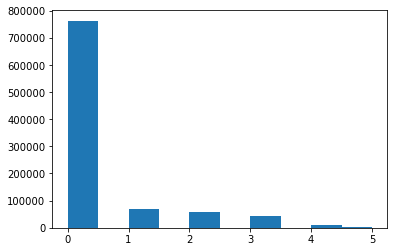

In [14]:
plt.hist(ratings["buy_level"], bins = np.arange(0,5.5,0.5))

(array([1.10000e+01, 0.00000e+00, 4.95000e+02, 0.00000e+00, 1.09610e+04,
        0.00000e+00, 4.75350e+04, 0.00000e+00, 1.50608e+05, 7.41244e+05]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

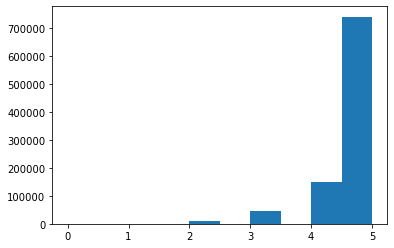

In [15]:
plt.hist(ratings["low_clac"], bins = np.arange(0,5.5,0.5))

(array([ 45279.,      0.,  90556.,      0., 135821.,      0., 181127.,
             0., 226398., 271673.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

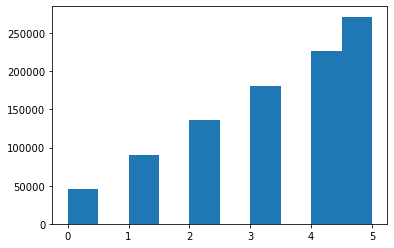

In [16]:
plt.hist(ratings["range_score"], bins = np.arange(0,5.5,0.5))

In [17]:
ratings["score"] = (ratings["buy_level"]*2 + ratings["low_clac"] + ratings["range_score"])/4

(array([1.90000e+01, 2.77100e+03, 4.93810e+04, 1.92885e+05, 3.51199e+05,
        2.60703e+05, 5.72280e+04, 2.83180e+04, 7.44900e+03, 9.01000e+02]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

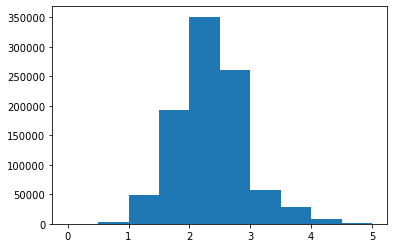

In [18]:
plt.hist(ratings["score"], bins = np.arange(0,5.5,0.5))

# 모델링

## LabelEncoding

In [19]:
le_c = LabelEncoder()
le_c = le_c.fit(ratings.cust)
ratings['cust']=le_c.transform(ratings.cust)
customer_info=pd.DataFrame(le_c.classes_, columns={'cust'})
customer_info['label']=range(0,len(ratings.cust.unique()))
customer_info.to_csv(aa+"_customer_info.csv",index=False)
customer_info

,cust,label
0,M000034966,0
1,M000136117,1
2,M000419293,2
3,M000494848,3
4,M000508243,4
...,...,...
18129,M999515910,18129
18130,M999599111,18130
18131,M999770689,18131
18132,M999849895,18132


In [20]:
le_p = LabelEncoder()
le_p = le_p.fit(ratings.pd_c)
ratings['pd_c']=le_p.transform(ratings.pd_c)
pd_info=pd.DataFrame(le_p.classes_, columns={'pd_c'})
pd_info['label']=range(0,len(ratings.pd_c.unique()))
pd_info.to_csv(aa+"_pd_info.csv",index=False)
pd_info

,pd_c,label
0,PD0001,0
1,PD0002,1
2,PD0003,2
3,PD0004,3
4,PD0005,4
...,...,...
1480,PD1926,1480
1481,PD1928,1481
1482,PD1929,1482
1483,PD1930,1483


In [21]:
# train test 분리
TRAIN_SIZE = 0.9
ratings = shuffle(ratings)
cutoff = int(TRAIN_SIZE * len(ratings))
ratings_train = ratings.iloc[:cutoff]
ratings_test = ratings.iloc[cutoff:]

In [22]:
users=A0.groupby(['cust','ages','ma_fem_dv'],as_index=False).count()
users=users[['cust','ages','ma_fem_dv']]
users['cust']=le_c.transform(users.cust)
users

,cust,ages,ma_fem_dv
0,0,40대,여성
1,1,30대,여성
2,2,40대,여성
3,3,30대,여성
4,4,50대,여성
...,...,...,...
18129,18129,40대,남성
18130,18130,40대,여성
18131,18131,30대,여성
18132,18132,20대,여성


In [23]:
ages=[]
for i in range(len(users)):
    users.ages[i]=users.ages[i][0:2]
users.ages=users.ages.astype('float')

<ipython-input-23-ab29fe5432dc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users.ages[i]=users.ages[i][0:2]


In [24]:
le_s = LabelEncoder()
le_s = le_s.fit(users.ma_fem_dv)
users['ma_fem_dv']=le_s.transform(users.ma_fem_dv)

customer_info['sex']=users['ma_fem_dv']
customer_info

,cust,label,sex
0,M000034966,0,1
1,M000136117,1,1
2,M000419293,2,1
3,M000494848,3,1
4,M000508243,4,1
...,...,...,...
18129,M999515910,18129,0
18130,M999599111,18130,1
18131,M999770689,18131,1
18132,M999849895,18132,1


In [25]:
users

,cust,ages,ma_fem_dv
0,0,40.0,1
1,1,30.0,1
2,2,40.0,1
3,3,30.0,1
4,4,50.0,1
...,...,...,...
18129,18129,40.0,0
18130,18130,40.0,1
18131,18131,30.0,1
18132,18132,20.0,1


In [26]:
L=len(customer_info)
train_asz = pd.merge(ratings_train, users, on='cust')[['ages','ma_fem_dv']]
test_asz = pd.merge(ratings_test, users, on='cust')[['ages','ma_fem_dv']]

## INPUT file (구매 경험이 없는 고객-상품 모음) 생성

In [27]:
ratings = pd.merge(ratings,users,how="left",on="cust")

#회귀분석을 이용한 score 관련 변수 확인하기
res = ols('score ~ ages+ma_fem_dv', data=ratings).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     305.7
Date:                Sun, 07 Aug 2022   Prob (F-statistic):          1.86e-133
Time:                        18:57:53   Log-Likelihood:            -7.7473e+05
No. Observations:              950854   AIC:                         1.549e+06
Df Residuals:                  950851   BIC:                         1.550e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1562      0.002    910.103      0.000       2.152       2.161
ages           0.0013    5.3e-05     24.519      0.000       0.001       0.001
ma_fem_dv      0.0037      0.001      3.006      0.003       0.001       0.006
==============================================================================
Omnibus:                    59292.028   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            91938.689
Skew:                           0.520   Prob(JB):                         0.00
Kurtosis:                       4.114   Cond. No.                         180.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
ratings.to_csv(aa+"_ratings.csv",index=False,encoding='utf-8-sig')
users.to_csv(aa+"_users.csv",index=False)

In [29]:
check = np.zeros(shape=(len(ratings["cust"].unique()), len(ratings["pd_c"].unique())), dtype=np.int8) - 999


for i in tqdm_notebook(range(len(ratings))):
    c_label = ratings.iloc[i,0]
    p_label = ratings.iloc[i,1]
    sco = ratings.iloc[i,-1]
    check[int(c_label)][int(p_label)] = sco
    
cust = np.where(check == -999)[0]
pd_c = np.where(check == -999)[1]
last = pd.DataFrame()
last["cust"] = cust
last["pd_c"] = pd_c
last = pd.merge(last,users,how="left",on="cust")
last.to_csv(aa+"_input.csv",index=False)

<ipython-input-29-ee852db894de>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(ratings))):


## Model Fitting

In [30]:
# Variable 초기화 
K = 200                             # Latent factor 수 
mu = ratings_train.score.mean()    # 전체 평균 
M = ratings.cust.max() + 1       
N = ratings.pd_c.max() + 1  

In [31]:
# Keras model
user = Input(shape=(1, ))
item = Input(shape=(1, ))
P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)

In [32]:
# Concatenate layers
P_embedding = Flatten()(P_embedding)
Q_embedding = Flatten()(Q_embedding)
user_bias = Flatten()(user_bias)
item_bias = Flatten()(item_bias)

In [33]:
age = Input(shape=(1, ))
age_embedding = Embedding(L, 3, embeddings_regularizer=l2())(age)
age_layer = Flatten()(age_embedding)

sex = Input(shape=(1, ))
sex_embedding = Embedding(L, 3, embeddings_regularizer=l2())(sex)
sex_layer = Flatten()(sex_embedding)

R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias, age_layer,sex_layer])

In [34]:
# Neural network
R = Dense(2048)(R)
R = Activation('relu')(R)
R = Dense(256)(R)
R = Activation('relu')(R)
R = Dense(1)(R)

In [35]:
model = Model(inputs=[user, item, age, sex], outputs=R)
model.compile(
  loss="mse",
  optimizer=SGD(),
  #optimizer=Adamax(),
  metrics=[RootMeanSquaredError()]
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
______________________________________________________________________________________________

In [36]:
callbacks = [EarlyStopping(monitor='val_loss',
                                           patience=3),
             ModelCheckpoint(filepath=aa+'_best_model.h5',
                                             monitor='val_loss',
                                             save_best_only=True)]

In [37]:
# Model fitting
result = model.fit(
  x=[ratings_train.cust.values, ratings_train.pd_c.values, train_asz.ages, train_asz.ma_fem_dv],
  y=ratings_train.score.values - mu,
  epochs=1000,
  batch_size=512,
  validation_data=(
    [ratings_test.cust.values, ratings_test.pd_c.values, test_asz.ages, test_asz.ma_fem_dv],
    ratings_test.score.values - mu
  ), callbacks = callbacks
)

Epoch 1/1000
1672/1672 [==============================] - 80s 47ms/step - loss: 24.9214 - root_mean_squared_error: 0.5428 - val_loss: 17.5862 - val_root_mean_squared_error: 0.5374
Epoch 2/1000
1672/1672 [==============================] - 79s 47ms/step - loss: 12.8925 - root_mean_squared_error: 0.5240 - val_loss: 9.1194 - val_root_mean_squared_error: 0.5046
Epoch 3/1000
1672/1672 [==============================] - 79s 47ms/step - loss: 6.7074 - root_mean_squared_error: 0.4885 - val_loss: 4.7730 - val_root_mean_squared_error: 0.4761
Epoch 4/1000
1672/1672 [==============================] - 82s 49ms/step - loss: 3.5406 - root_mean_squared_error: 0.4715 - val_loss: 2.5508 - val_root_mean_squared_error: 0.4667t_mean_squared_err
Epoch 5/1000
1672/1672 [==============================] - 79s 47ms/step - loss: 1.9200 - root_mean_squared_error: 0.4652 - val_loss: 1.4130 - val_root_mean_squared_error: 0.46303s - loss: 1.9
Epoch 6/1000
1672/1672 [==============================] - 79s 47ms/step - l

## 결과 확인

In [38]:
keras_model_best = load_model(aa+'_best_model.h5')

<Figure size 576x576 with 0 Axes>

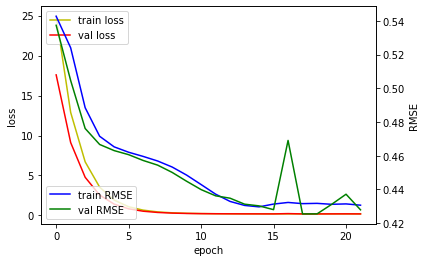

In [39]:
# Plot RMSE
plt.figure(figsize=(8,8))

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(result.history['loss'], 'y', label = 'train loss')
loss_ax.plot(result.history['val_loss'], 'r', label = 'val loss')

acc_ax.plot(result.history['root_mean_squared_error'], 'b', label = 'train RMSE')
acc_ax.plot(result.history['val_root_mean_squared_error'], 'g', label = 'val RMSE')


loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('RMSE')

loss_ax.legend(loc = 'upper left')
acc_ax.legend(loc = 'lower left')

plt.savefig(aa+'_model_loss.png')

In [40]:
# Prediction
user_ids = ratings_test.cust.values[100:110]
pd_ids = ratings_test.pd_c.values[100:110]
user_test = test_asz[100:110]
predictions = keras_model_best.predict([user_ids, pd_ids, user_test.ages, user_test.ma_fem_dv]) + mu
print("Actuals: \n", ratings_test[100:110]["score"])
print()
print("Predictions: \n", predictions)

Actuals: 
 505275    2.75
92667     2.50
479671    2.50
85781     1.75
213294    3.50
134636    1.75
805112    1.25
930121    2.00
700929    2.50
889518    2.50
Name: score, dtype: float64

Predictions: 
 [[2.5877147]
 [2.2173667]
 [2.1888244]
 [2.323049 ]
 [2.6913745]
 [1.8371711]
 [1.7105355]
 [2.1818814]
 [2.4152963]
 [2.8329535]]


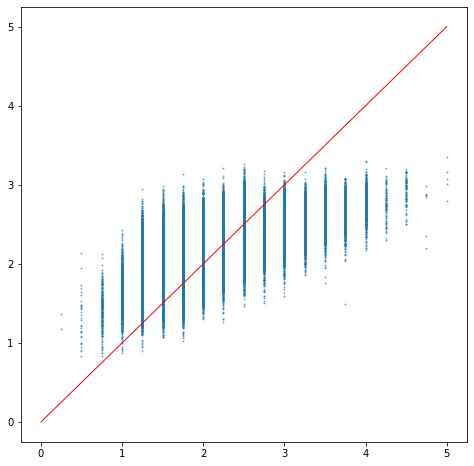

In [41]:
# Pred plot
user_ids = ratings_test.cust.values
pd_ids = ratings_test.pd_c.values
user_test = test_asz
predictions = keras_model_best.predict([user_ids, pd_ids, user_test.ages, user_test.ma_fem_dv]) + mu


plt.figure(figsize=(8,8))
plt.scatter(x = ratings_test.score, y = predictions, s=1, alpha = 0.5)
plt.plot([0, 5], [0, 5], color="red", lw=1, linestyle='solid')
plt.savefig(aa+'_test_predplot.png')

# OUTPUT file 생성

In [42]:
last["pred_score"] = keras_model_best.predict([last["cust"], last["pd_c"], last["ages"], last["ma_fem_dv"]]) + mu

In [43]:
last

,cust,pd_c,ages,ma_fem_dv,pred_score
0,0,0,40.0,1,1.743486
1,0,1,40.0,1,1.385312
2,0,2,40.0,1,1.602425
3,0,3,40.0,1,1.498590
4,0,4,40.0,1,1.548724
...,...,...,...,...,...
25978131,18133,1480,50.0,1,1.890923
25978132,18133,1481,50.0,1,1.845900
25978133,18133,1482,50.0,1,1.811886
25978134,18133,1483,50.0,1,1.840181


In [44]:
last.to_csv(aa+"_output.csv",index=False)